In [3]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from pathlib import Path
import jax.numpy as jnp
import math

In [4]:
logs_base_path = "/home/dc755/idiots/logs/"
experiment_names = ["mnist_grokking-800"]

In [5]:
min_dots, max_dots = math.inf, -math.inf

for experiment_name in experiment_names:
  checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")

  with open(checkpoint_dir, "r") as json_file:
    df = pd.read_json(json_file)

  max_dots = max(max_dots, max(df["dots"]))
  min_dots = min(min_dots, min(df["dots"]))

In [ ]:
initial_svm_accuracies = []

for experiment_name in experiment_names:
    checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")
    
    with open(checkpoint_dir, "r") as json_file:
        df = pd.read_json(json_file)
    
    initial_svm_accuracies.append(df["initial_svm_accuracy"].values[0])

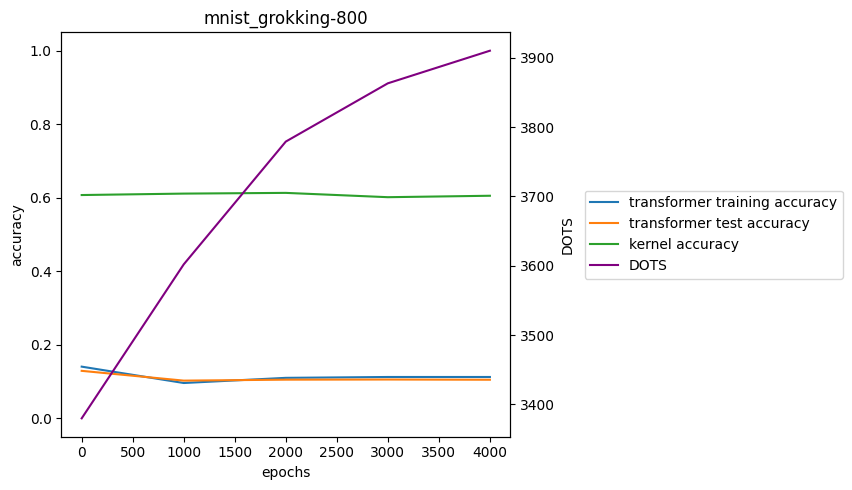

In [6]:
num_experiments = len(experiment_names)

fig, axs = plt.subplots(1, num_experiments, figsize=(2 + num_experiments * 7, 5), sharey=True)

for i, experiment_name in enumerate(experiment_names):
    
    checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")

    with open(checkpoint_dir, "r") as json_file:
        df = pd.read_json(json_file)


    if not "step" in df.keys(): 
      df["step"] = df.index * 5

    ax1 = axs if num_experiments == 1 else axs[i]
    ax2 = ax1.twinx()

    sns.lineplot(data=df, x="step", y="training_acc", label="transformer training accuracy", ax=ax1)
    sns.lineplot(data=df, x="step", y="test_acc", label="transformer test accuracy", ax=ax1)
    sns.lineplot(data=df, x="step", y="svm_accuracy", label="kernel accuracy", ax=ax1)
    
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("accuracy")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend().set_visible(False)

    sns.lineplot(data=df, x="step", y="dots", label="DOTS", color="purple", ax=ax2)
    
    if i == len(experiment_names) - 1:
      ax2.set_ylabel("DOTS")
    else: 
      ax2.set_ylabel("")

    visual_buffer = (max_dots - min_dots) * 0.05
    if min_dots != max_dots: 
      ax2.set_ylim([min_dots - visual_buffer, max_dots + visual_buffer])

    lines, labels = ax1.get_legend_handles_labels() 
    lines2, labels2 = ax2.get_legend_handles_labels() 

    if i == len(experiment_names) - 1:
      ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5))
    else: 
      ax2.legend().set_visible(False)
      ax2.tick_params(axis='y', which='both', labelright=False)

    ax1.set_title(experiment_name)

fig.tight_layout()

In [21]:
s5_checkpoint_dir = Path(logs_base_path, "results", "s5.json")

with open(checkpoint_dir, "r") as json_file:
  df = pd.read_json(json_file)

print(jnp.array(df["kernel"][0]))

2024-02-27 15:09:42.830343: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[[4204172.    925925.5   885506.8  ... 1578842.   1160005.6  1163046.  ]
 [ 925925.5  1900382.4   412150.75 ...  860721.3   846997.44  553076.6 ]
 [ 885506.8   412150.75 2016224.9  ...  606326.5   596461.44  701038.94]
 ...
 [1578842.    860721.3   606326.5  ... 2691376.8   949640.1  1080317.9 ]
 [1160005.6   846997.44  596461.44 ...  949640.1  3049038.    760038.9 ]
 [1163046.    553076.6   701038.94 ... 1080317.9   760038.9  2706633.8 ]]
